In [1]:
import numpy as np
import sys

sys.path.append('/home/aseem/python_modules/cosmology/')
from universe import Cosmology

from time import time
import gc
import copy

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
import matplotlib.colors as pltcol

In [2]:
import numpy as np
import sys

sys.path.append('/home/aseem/python_modules/cosmology/')
from universe import Cosmology

from time import time
import gc

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
import matplotlib.colors as pltcol

In [3]:
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 14 # 14
mpl.rcParams['legend.labelspacing'] = 0.25
FS = 18
FS2 = 15
FS3 = 13
FSL = 22

mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.minor.size'] = 3

#mpl.rcParams.keys()

# Cosmological Parameter Variations
### Impact of varying Sahyadri cosmological parameters on non-linear cosmological statistics
Statistics explored <span style="color:red"> (all at $z=0$)</span>:
1. Non-linear matter power spectrum (HALOFIT)
2. Halo mass function (Tinker+ 2008)
3. Linear halo bias (Tinker+ 2010)

## Fiducial cosmology

In [4]:
Lbox = 200.0
Npart = 256
Npart_target = 2048

In [5]:
Om = 0.3137721
Ob = 0.0493017
Ok = 0.0
h = 0.6736
ns = 0.9649
As = 2.098903e-9
w0 = -1.0

Pklin = 'class'

start_time = time()
co_fid = Cosmology(Om=Om,Ob=Ob,Ok=Ok,hubble=h,ns=ns,As=As,wDE0=w0,Pklin=Pklin,verbose=False)

kmin = (2*np.pi/Lbox) 
kmax = np.pi*Npart/Lbox
kbins = np.logspace(np.log10(kmin),np.log10(kmax),30)
dlnk = np.log(kbins[1]/kbins[0])
kmid = np.sqrt(kbins[1:]*kbins[:-1])

Vk = 8*np.pi/3*kmid**3*np.cosh(1.5*dlnk)
Nk = Vk*Lbox**3/(2*np.pi)**3
rel_err_Pk = np.sqrt(2/(Nk+1e-20))
kmid *= co_fid.hubble # convert to Mpc^-1 for plotting

mtab = np.logspace(10,15.5,30) # Msun/h
# mf_fid,b1_fid = co_fid.massfuncbiasTinker(mtab)
mvals = mtab/co_fid.hubble # values in Msun

co_fid.time_this(start_time)

0 min 3.48 seconds



## Calculation and plotting function

In [6]:
def derivative(f_pp,f_p,f0,f_m,f_mm,h,order=1):
    """ Return 5-point estimate of 1st or 2nd order derivatives. Error in each case is O(h^4). """
    out = np.zeros_like(f0)
    if order==1:
        out = -f_pp + 8*f_p - 8*f_m + f_mm
    elif order==2:
        out = -f_pp + 16*f_p - 30*f0 + 16*f_m - f_mm
        out /= h
    else:
        raise Exception('Only order = 1 and 2 supported.')
    out /= (12*h)
    return out

def vary_and_plot(param,var,cf,mvals,var_acc,Lbox=200,Npart=256,Npart_target=2048,sig_thresh=4,
                  k_sim=None,rePk_sim=None):
    """ Vary parameter by specified amount and factor 2 of this amount, up and down, 
        and plot results for nonlinear matter power spectrum, halo mass function and linear halo bias.
        -- param: string, one of ['Om','Ob','Ok','h','As','ns','w0']
        -- var: required variation
        -- cf: instance of Cosmology with fiducial parameters
        -- mvals: array of mass values in Msun
        -- var_acc: variation to be used for accurate derivative calculation (make this <~0.1% of fiducial)
        -- Lbox: box size in Mpc/h_fid
        -- Npart: number of particles along each dimension in current simulation
        -- Npart_target: number of particles along each dimension in target simulation
        -- sig_thresh: precision threshold for checking if param variations are measurable
        -- k_sim,rePk_sim: expected bins and relative error on Pk measurements in current simulation.
    """
    if not isinstance(cf,Cosmology):
        raise Exception('cf must be valid instance of Cosmology with fiducial parameters')

    # label dictionary for plots
    ld = {'Om':"\\Omega_{\\rm m}",'Ob':"\\Omega_{\\rm b}",'Ok':"\\Omega_{\\rm k}",
          'h':"h",'ns':"n_{{\\rm s}}",'As':"A_{{\\rm s}}",'w0':"w_{{0}}"}
    
    pd_fid = {'Om':cf.Om,'Ob':cf.Ob,'Ok':cf.Ok,'h':cf.hubble,'ns':cf.ns,'As':cf.As,'w0':cf.wDE0}
    pd_p = copy.deepcopy(pd_fid)
    pd_m = copy.deepcopy(pd_fid)
    pd_pp = copy.deepcopy(pd_fid)
    pd_mm = copy.deepcopy(pd_fid)

    if param not in pd_p.keys():
        raise ValueError('param must be one of ['+','.join([key for key in pd_p.keys()])+']')
    
    print('Varying '+param+'...')
    
    pd_p[param] += var
    pd_pp[param] += 2*var
    pd_m[param] -= var
    pd_mm[param] -= 2*var
        
    start_time = time()
    co_p = Cosmology(Om=pd_p['Om'],Ob=pd_p['Ob'],Ok=pd_p['Ok'],hubble=pd_p['h'],
                     ns=pd_p['ns'],As=pd_p['As'],wDE0=pd_p['w0'],Pklin=cf.Pklin,verbose=cf.verbose)
    co_pp = Cosmology(Om=pd_pp['Om'],Ob=pd_pp['Ob'],Ok=pd_pp['Ok'],hubble=pd_pp['h'],
                      ns=pd_pp['ns'],As=pd_pp['As'],wDE0=pd_pp['w0'],Pklin=cf.Pklin,verbose=cf.verbose)
    co_m = Cosmology(Om=pd_m['Om'],Ob=pd_m['Ob'],Ok=pd_m['Ok'],hubble=pd_m['h'],
                     ns=pd_m['ns'],As=pd_m['As'],wDE0=pd_m['w0'],Pklin=cf.Pklin,verbose=cf.verbose)
    co_mm = Cosmology(Om=pd_mm['Om'],Ob=pd_mm['Ob'],Ok=pd_mm['Ok'],hubble=pd_mm['h'],
                      ns=pd_mm['ns'],As=pd_mm['As'],wDE0=pd_mm['w0'],Pklin=cf.Pklin,verbose=cf.verbose)
    print('... transfer functions calculated')

    Dnl_fid = cf.nonlinearpower(model=1)
    kvals = cf.ktab_lin*cf.hubble # values in Mpc^-1
    mf_fid,b1_fid = cf.massfuncbiasTinker(mvals*cf.hubble)
    dlnm = mvals[1]/mvals[0]
    Nh = mf_fid*dlnm*Lbox**3
    remf_sim = 1/(np.sqrt(Nh) + 1e-20)
    mpart = 8.0775e9*(512/Npart_target)**3*(cf.Om/0.25)*(Lbox/250)**3/cf.hubble # particle mass or target config in Msun
    N_thresh = Nh.cumsum()
    N_thresh = N_thresh[-1] - N_thresh
    print('... fiducial statistics calculated')
    
    print('Variations...')
    print('... power spectrum')
    Dnl_p = co_p.nonlinearpower(model=1)
    Dnl_pp = co_pp.nonlinearpower(model=1)
    Dnl_m = co_m.nonlinearpower(model=1)
    Dnl_mm = co_mm.nonlinearpower(model=1)

    if param == 'h':
        # need interpolation since code internally uses h/Mpc units for k values
        print('... ... interpolating for hubble variation')
        Dnl_p = np.exp(np.interp(np.log(kvals),np.log(co_p.ktab_lin*co_p.hubble),np.log(Dnl_p)))
        Dnl_pp = np.exp(np.interp(np.log(kvals),np.log(co_pp.ktab_lin*co_pp.hubble),np.log(Dnl_pp)))
        Dnl_m = np.exp(np.interp(np.log(kvals),np.log(co_m.ktab_lin*co_m.hubble),np.log(Dnl_m)))
        Dnl_mm = np.exp(np.interp(np.log(kvals),np.log(co_m.ktab_lin*co_mm.hubble),np.log(Dnl_mm)))
    
    print('... mass function and bias')
    # for mf and bias, explicitly evaluate at correct values of Msun/h
    mf_p,b1_p = co_p.massfuncbiasTinker(mvals*co_p.hubble)
    mf_pp,b1_pp = co_pp.massfuncbiasTinker(mvals*co_pp.hubble)
    mf_m,b1_m = co_m.massfuncbiasTinker(mvals*co_m.hubble)
    mf_mm,b1_mm = co_mm.massfuncbiasTinker(mvals*co_mm.hubble)
    
    if param == 'h':
        # need scaling since code outputs in (h/Mpc)^3 units for mf values
        print('... ... rescaling for hubble variation')
        mf_p *= (co_p.hubble/cf.hubble)**3
        mf_pp *= (co_pp.hubble/cf.hubble)**3
        mf_m *= (co_m.hubble/cf.hubble)**3
        mf_mm *= (co_mm.hubble/cf.hubble)**3
    
    print('Estimating derivatives...')
    print('... from specified variations')
    D_Dnl = derivative(Dnl_pp,Dnl_p,Dnl_fid,Dnl_m,Dnl_mm,var,order=1)
    D_mf = derivative(mf_pp,mf_p,mf_fid,mf_m,mf_mm,var,order=1)
    D_b1 = derivative(b1_pp,b1_p,b1_fid,b1_m,b1_mm,var,order=1)
    
    print('... accurately')
    pd_p_acc = copy.deepcopy(pd_fid)
    pd_m_acc = copy.deepcopy(pd_fid)
    pd_pp_acc = copy.deepcopy(pd_fid)
    pd_mm_acc = copy.deepcopy(pd_fid)
    pd_p_acc[param] += var_acc
    pd_m_acc[param] -= var_acc
    pd_pp_acc[param] += 2*var_acc
    pd_mm_acc[param] -= 2*var_acc
    
    start_time = time()
    co_p_acc = Cosmology(Om=pd_p_acc['Om'],Ob=pd_p_acc['Ob'],Ok=pd_p_acc['Ok'],hubble=pd_p_acc['h'],
                     ns=pd_p_acc['ns'],As=pd_p_acc['As'],wDE0=pd_p_acc['w0'],Pklin=cf.Pklin,verbose=cf.verbose)
    co_m_acc = Cosmology(Om=pd_m_acc['Om'],Ob=pd_m_acc['Ob'],Ok=pd_m_acc['Ok'],hubble=pd_m_acc['h'],
                     ns=pd_m_acc['ns'],As=pd_m_acc['As'],wDE0=pd_m_acc['w0'],Pklin=cf.Pklin,verbose=cf.verbose)
    co_pp_acc = Cosmology(Om=pd_pp_acc['Om'],Ob=pd_pp_acc['Ob'],Ok=pd_pp_acc['Ok'],hubble=pd_pp_acc['h'],
                     ns=pd_pp_acc['ns'],As=pd_pp_acc['As'],wDE0=pd_pp_acc['w0'],Pklin=cf.Pklin,verbose=cf.verbose)
    co_mm_acc = Cosmology(Om=pd_mm_acc['Om'],Ob=pd_mm_acc['Ob'],Ok=pd_mm_acc['Ok'],hubble=pd_mm_acc['h'],
                     ns=pd_mm_acc['ns'],As=pd_mm_acc['As'],wDE0=pd_mm_acc['w0'],Pklin=cf.Pklin,verbose=cf.verbose)
    print('... ... transfer functions calculated')
    
    print('... power spectrum')
    Dnl_p_acc = co_p_acc.nonlinearpower(model=1)
    Dnl_m_acc = co_m_acc.nonlinearpower(model=1)
    Dnl_pp_acc = co_pp_acc.nonlinearpower(model=1)
    Dnl_mm_acc = co_mm_acc.nonlinearpower(model=1)

    if param == 'h':
        # need interpolation since code internally uses h/Mpc units for k values
        print('... ... ... interpolating for hubble variation')
        Dnl_p_acc = np.exp(np.interp(np.log(kvals),np.log(co_p_acc.ktab_lin*co_p_acc.hubble),np.log(Dnl_p_acc)))
        Dnl_m_acc = np.exp(np.interp(np.log(kvals),np.log(co_m_acc.ktab_lin*co_m_acc.hubble),np.log(Dnl_m_acc)))
        Dnl_pp_acc = np.exp(np.interp(np.log(kvals),np.log(co_pp_acc.ktab_lin*co_pp_acc.hubble),np.log(Dnl_pp_acc)))
        Dnl_mm_acc = np.exp(np.interp(np.log(kvals),np.log(co_mm_acc.ktab_lin*co_mm_acc.hubble),np.log(Dnl_mm_acc)))
    
    print('... ... mass function and bias')
    # for mf and bias, explicitly evaluate at correct values of Msun/h
    mf_p_acc,b1_p_acc = co_p_acc.massfuncbiasTinker(mvals*co_p_acc.hubble)
    mf_m_acc,b1_m_acc = co_m_acc.massfuncbiasTinker(mvals*co_m_acc.hubble)
    mf_pp_acc,b1_pp_acc = co_pp_acc.massfuncbiasTinker(mvals*co_pp_acc.hubble)
    mf_mm_acc,b1_mm_acc = co_mm_acc.massfuncbiasTinker(mvals*co_mm_acc.hubble)
    
    if param == 'h':
        # need scaling since code outputs in (h/Mpc)^3 units for mf values
        print('... ... ... rescaling for hubble variation')
        mf_p_acc *= (co_p_acc.hubble/cf.hubble)**3
        mf_m_acc *= (co_m_acc.hubble/cf.hubble)**3
        mf_pp_acc *= (co_pp_acc.hubble/cf.hubble)**3
        mf_mm_acc *= (co_mm_acc.hubble/cf.hubble)**3

    # D_Dnl_acc = (Dnl_p_acc - Dnl_m_acc)/(2*var_acc)
    # D_mf_acc = (mf_p_acc - mf_m_acc)/(2*var_acc)
    # D_b1_acc = (b1_p_acc - b1_m_acc)/(2*var_acc)
    D_Dnl_acc = derivative(Dnl_pp_acc,Dnl_p_acc,Dnl_fid,Dnl_m_acc,Dnl_mm_acc,var_acc,order=1)
    D_mf_acc = derivative(mf_pp_acc,mf_p_acc,mf_fid,mf_m_acc,mf_mm_acc,var_acc,order=1)
    D_b1_acc = derivative(b1_pp_acc,b1_p_acc,b1_fid,b1_m_acc,b1_mm_acc,var_acc,order=1)
    print('... ... derivatives calculated')
    
    cf.time_this(start_time)

    print('Plotting...')
    FSIZE = 5
    fig = plt.figure(figsize=(3*FSIZE,FSIZE))
    gs = gridspec.GridSpec(1,3,width_ratios=[1,1,1],wspace=0.05)
    Ymin,Ymax = -0.3,0.3
    ########################################
    # pow spec ratio
    ax = plt.subplot(gs[0])
    ax.set_xscale('log')
    Xmin = 2*np.pi/Lbox*cf.hubble
    Xmax = np.pi*Npart_target/Lbox*cf.hubble
    ax.set_xlim(Xmin,Xmax)
    ax.set_ylim(Ymin,Ymax)
    ax.set_xlabel("$k\\,({\\rm Mpc}^{{-1}})$")
    ax.set_ylabel('variation / fiducial - 1')
    
    ax.plot(kvals,Dnl_pp/Dnl_fid-1,'r--',label='$(++)$')
    ax.plot(kvals,Dnl_p/Dnl_fid-1,'r-',label='$(+)$')
    ax.plot(kvals,Dnl_m/Dnl_fid-1,'b-',label='$(-)$')
    ax.plot(kvals,Dnl_mm/Dnl_fid-1,'b--',label='$(--)$')
    ax.fill_between(k_sim,rePk_sim,-rePk_sim,color='g',alpha=0.15,ls='-',lw=0.5)
    ax.fill_between(k_sim,sig_thresh*rePk_sim,-sig_thresh*rePk_sim,color='g',alpha=0.075,ls='-',lw=0.5)
    
    var_text = '$'+ld[param]+'$ variation'
    ax.text(4*Xmin,Ymax/1.5,var_text,fontsize=FS2)
    ax.text(np.sqrt(Xmin*Xmax),Ymin/1.2,'nonlinear $P_{{\\rm mm}}(k)$',fontsize=FS2)
    ax.axhline(0.0,c='k',ls='--',lw=1)
    ax.axhline(0.05,c='k',ls=':',lw=0.5)
    ax.axhline(-0.05,c='k',ls=':',lw=0.5)
    ax.axvline(np.pi*Npart/Lbox,c='purple',ls='-',lw=0.5)
    ax.minorticks_on()
    ########################################
    
    ########################################
    # mass func ratio
    ax = plt.subplot(gs[1])
    ax.set_xscale('log')
    Xmin = 100*mpart
    Xmax = mvals[N_thresh > 10].max()
    # Xmin = mvals[0]/1.5
    # Xmax = mvals[-1]*1.5
    ax.set_xlim(Xmin,Xmax)
    ax.set_ylim(Ymin,Ymax)
    ax.set_xlabel("$m\\,(M_{{\\odot}})$")
    ax.set_yticklabels('')
    
    ax.plot(mvals,mf_pp/mf_fid-1,'r--',label='$(++)$')
    ax.plot(mvals,mf_p/mf_fid-1,'r-',label='$(+)$')
    ax.plot(mvals,mf_m/mf_fid-1,'b-',label='$(-)$')
    ax.plot(mvals,mf_mm/mf_fid-1,'b--',label='$(--)$')
    ax.fill_between(mvals,remf_sim,-remf_sim,color='g',alpha=0.15,ls='-',lw=0.5)
    ax.fill_between(mvals,sig_thresh*remf_sim,-sig_thresh*remf_sim,color='g',alpha=0.075,ls='-',lw=0.5)
    
    ax.text(5*Xmin,Ymin/1.2,'mass function',fontsize=FS2)
    ax.axhline(0.0,c='k',ls='--',lw=1)
    ax.axhline(0.05,c='k',ls=':',lw=0.5)
    ax.axhline(-0.05,c='k',ls=':',lw=0.5)
    ax.axvline(Xmin*Npart_target/Npart,c='purple',ls='-',lw=0.5)
    ax.legend(loc='upper left')
    ax.minorticks_on()
    ########################################
    
    ########################################
    # bias ratio
    ax = plt.subplot(gs[2])
    ax.set_xscale('log')
    # Xmin = mvals[0]/1.5
    # Xmax = mvals[-1]*1.5
    ax.set_xlim(Xmin,Xmax)
    ax.set_ylim(Ymin,Ymax)
    ax.set_xlabel("$m\\,(M_{{\\odot}})$")
    ax.set_yticklabels('')
    
    ax.plot(mvals,b1_pp/b1_fid-1,'r--',label='$(++)$')
    ax.plot(mvals,b1_p/b1_fid-1,'r-',label='$(+)$')
    ax.plot(mvals,b1_m/b1_fid-1,'b-',label='$(-)$')
    ax.plot(mvals,b1_mm/b1_fid-1,'b--',label='$(--)$')

    if param in ['Ok','w0']:
        ax.text(5*Xmin,0.1,'EXTRAPOLATION',color='crimson',fontsize=FS3,fontweight='bold')
    ax.text(np.sqrt(Xmin*Xmax),Ymin/1.2,'linear bias',fontsize=FS2)
    ax.axhline(0.0,c='k',ls='--',lw=1)
    ax.axhline(0.05,c='k',ls=':',lw=0.5)
    ax.axhline(-0.05,c='k',ls=':',lw=0.5)
    ax.axvline(Xmin*Npart_target/Npart,c='purple',ls='-',lw=0.5)
    ax.minorticks_on()
    
    plt.show()

    ############################################
    # Derivatives
    ############################################
    FSIZE = 5
    fig = plt.figure(figsize=(3*FSIZE,FSIZE))
    gs = gridspec.GridSpec(1,3,width_ratios=[1,1,1],wspace=0.05)
    Ymin,Ymax = -0.05,0.05
    ########################################
    # pow spec ratio
    ax = plt.subplot(gs[0])
    ax.set_xscale('log')
    Xmin = 2*np.pi/Lbox*cf.hubble
    Xmax = np.pi*Npart_target/Lbox*cf.hubble
    ax.set_xlim(Xmin,Xmax)
    ax.set_ylim(Ymin,Ymax)
    ax.set_xlabel("$k\\,({\\rm Mpc}^{{-1}})$")
    ax.set_ylabel('estimated / true - 1')
    ax.plot(kvals,D_Dnl/D_Dnl_acc-1,'k-')
    ax.fill_between(k_sim,rePk_sim,-rePk_sim,color='g',alpha=0.15,ls='-',lw=0.5)
    
    var_text = '$'+ld[param]+'$ variation'
    ax.text(4*Xmin,Ymax/1.5,var_text,fontsize=FS2)
    ax.text(np.sqrt(Xmin*Xmax),Ymin/1.2,'$\\partial P_{{\\rm mm}}(k)/\\partial '+ld[param]+'$',fontsize=FS2)
    ax.axhline(0.0,c='k',ls='--',lw=1)
    ax.axhline(0.01,c='k',ls=':',lw=0.5)
    ax.axhline(-0.01,c='k',ls=':',lw=0.5)
    ax.axvline(np.pi*Npart/Lbox,c='purple',ls='-',lw=0.5)
    ax.minorticks_on()
    ########################################
    
    ########################################
    # mass func ratio
    ax = plt.subplot(gs[1])
    ax.set_xscale('log')
    Xmin = 100*mpart
    Xmax = mvals[N_thresh > 10].max()
    ax.set_xlim(Xmin,Xmax)
    ax.set_ylim(Ymin,Ymax)
    ax.set_xlabel("$m\\,(M_{{\\odot}})$")
    ax.set_yticklabels('')
    
    ax.plot(mvals,D_mf/D_mf_acc-1,'k-')
    ax.fill_between(mvals,remf_sim,-remf_sim,color='g',alpha=0.15,ls='-',lw=0.5)
    
    ax.text(5*Xmin,Ymin/1.2,'$\\partial n(m)/\\partial '+ld[param]+'$',fontsize=FS2)
    ax.axhline(0.0,c='k',ls='--',lw=1)
    ax.axhline(0.01,c='k',ls=':',lw=0.5)
    ax.axhline(-0.01,c='k',ls=':',lw=0.5)
    ax.axvline(Xmin*Npart_target/Npart,c='purple',ls='-',lw=0.5)
    ax.minorticks_on()
    ########################################
    
    ########################################
    # bias ratio
    ax = plt.subplot(gs[2])
    ax.set_xscale('log')
    # Xmin = mvals[0]/1.5
    # Xmax = mvals[-1]*1.5
    ax.set_xlim(Xmin,Xmax)
    ax.set_ylim(Ymin,Ymax)
    ax.set_xlabel("$m\\,(M_{{\\odot}})$")
    ax.set_yticklabels('')
    
    ax.plot(mvals,D_b1/D_b1_acc-1,'k-')

    if param in ['Ok','w0']:
        ax.text(5*Xmin,Ymax/1.5,'EXTRAPOLATION',color='crimson',fontsize=FS3,fontweight='bold')
    ax.text(np.sqrt(Xmin*Xmax),Ymin/1.2,'$\\partial b_{{1}}(m)/\\partial '+ld[param]+'$',fontsize=FS2)
    ax.axhline(0.0,c='k',ls='--',lw=1)
    ax.axhline(0.01,c='k',ls=':',lw=0.5)
    ax.axhline(-0.01,c='k',ls=':',lw=0.5)
    ax.axvline(Xmin*Npart_target/Npart,c='purple',ls='-',lw=0.5)
    ax.minorticks_on()
    
    plt.show()
    return

## $\Omega_{\rm m} \pm 5\%$

Varying Om...
... transfer functions calculated
type_dict None selected. Using CDM transfer function.
... fiducial statistics calculated
Variations...
... power spectrum
... mass function and bias
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
Estimating derivatives...
... from specified variations
... accurately
... ... transfer functions calculated
... power spectrum
... ... mass function and bias
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
... ... derivatives calculated
0 min 14.25 seconds

Plotting...


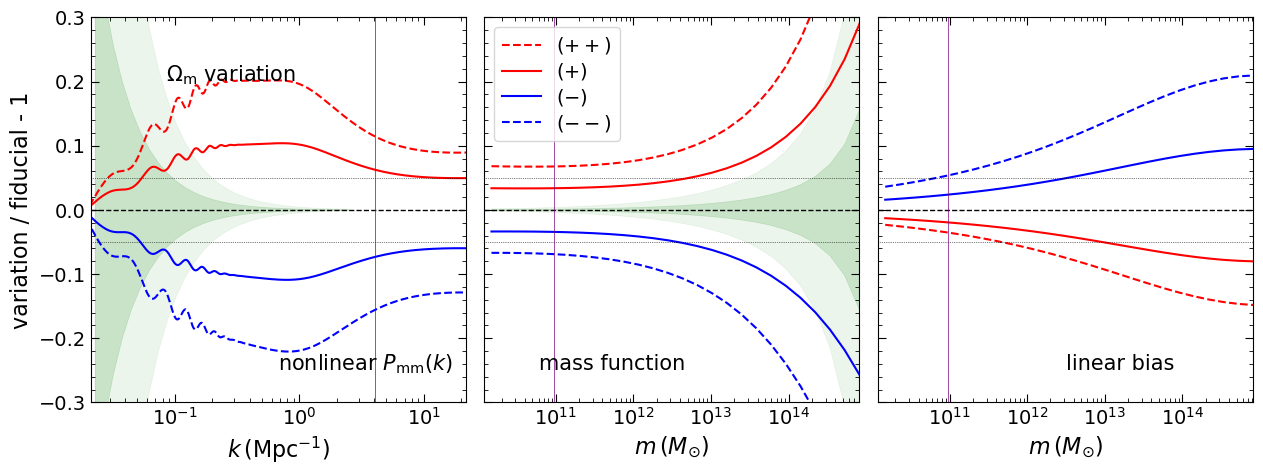

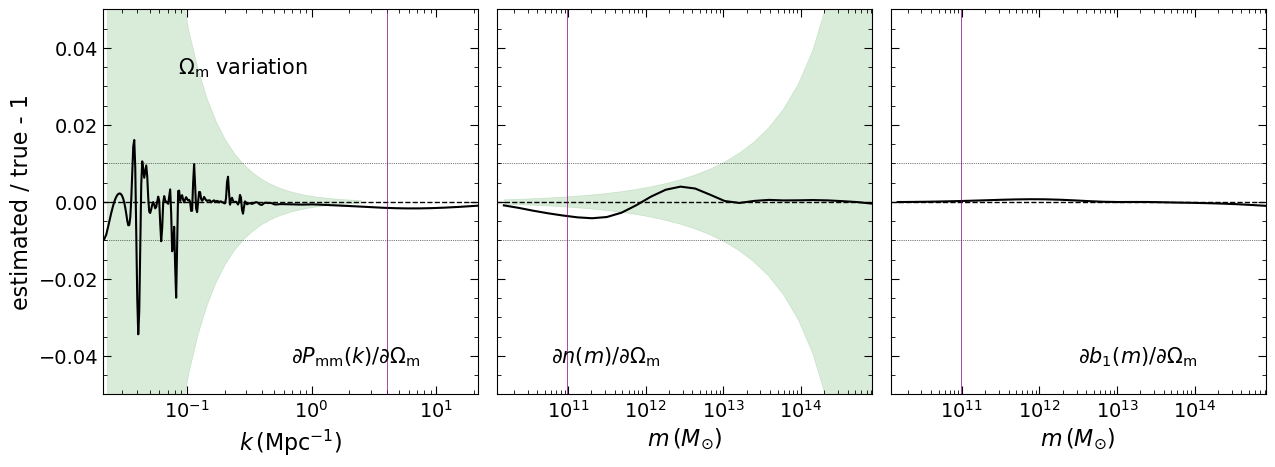

In [24]:
vary_and_plot('Om',0.05*co_fid.Om,co_fid,mvals,var_acc=1e-3*co_fid.Om,sig_thresh=3.0,k_sim=kmid,rePk_sim=rel_err_Pk)

## $\Omega_{\rm b} \pm 10\%$
Quite challenging. Very large variations needed to reliably see differences at high masses, but these then increase systematic errors at small masses.

Varying Ob...
... transfer functions calculated
type_dict None selected. Using CDM transfer function.
... fiducial statistics calculated
Variations...
... power spectrum
... mass function and bias
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
Estimating derivatives...
... from specified variations
... accurately
... ... transfer functions calculated
... power spectrum
... ... mass function and bias
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
... ... derivatives calculated
0 min 14.75 seconds

Plotting...


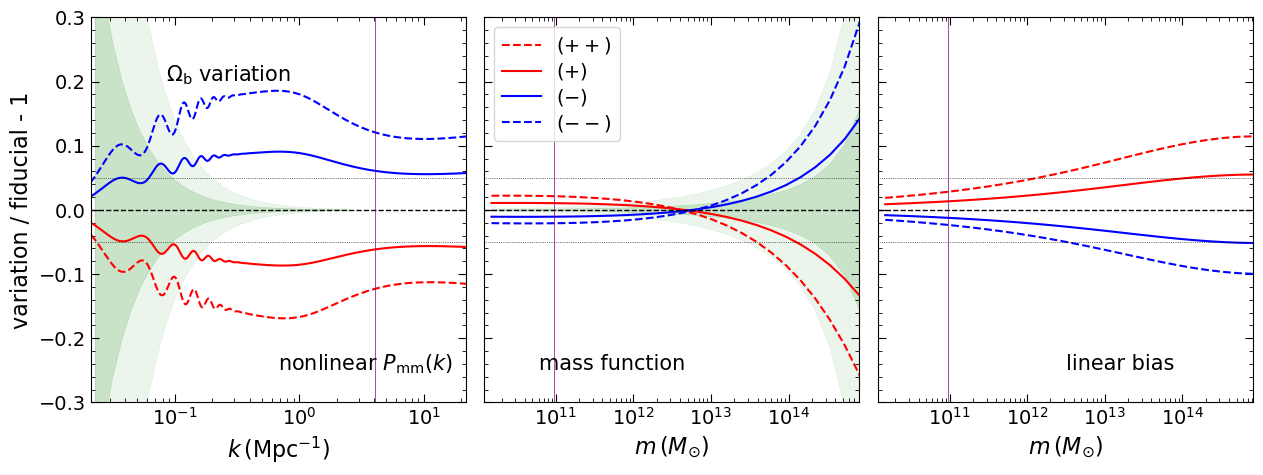

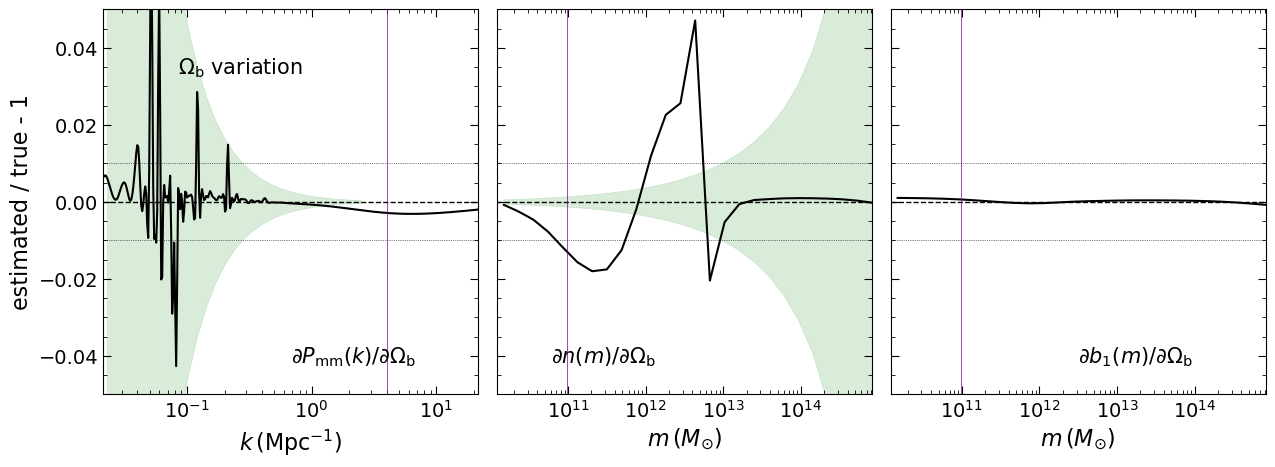

In [22]:
vary_and_plot('Ob',0.1*co_fid.Ob,co_fid,mvals,var_acc=1e-3*co_fid.Ob,sig_thresh=3.0,k_sim=kmid,rePk_sim=rel_err_Pk)

## $n_{\rm s} \pm 10\%$
#### <span style="color:red"> Derivative seems accurate enough that 2 points may suffice instead of 4 </span>

Varying ns...
... transfer functions calculated
type_dict None selected. Using CDM transfer function.
... fiducial statistics calculated
Variations...
... power spectrum
... mass function and bias
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
Estimating derivatives...
... from specified variations
... accurately
... ... transfer functions calculated
... power spectrum
... ... mass function and bias
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
... ... derivatives calculated
0 min 14.98 seconds

Plotting...


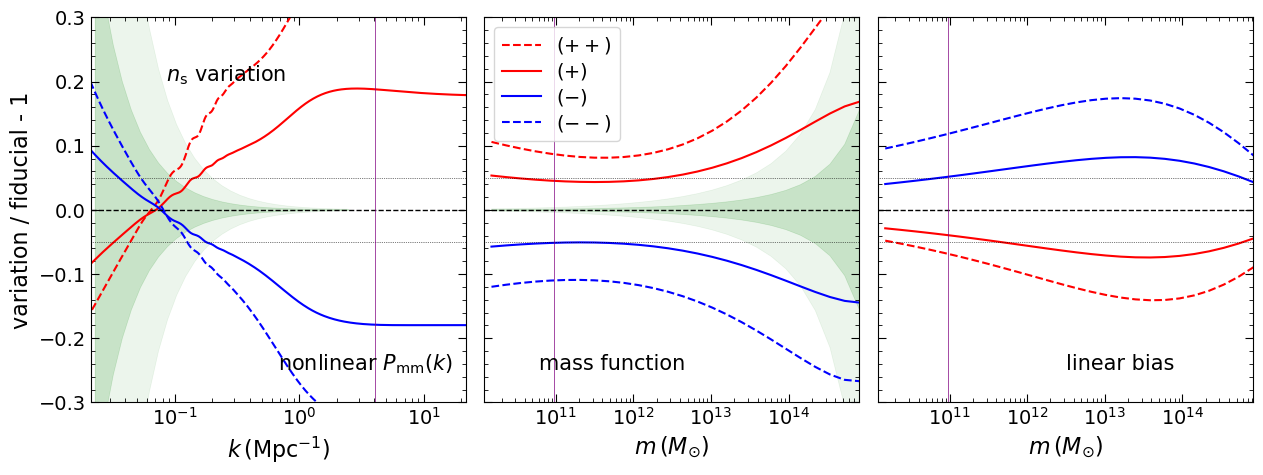

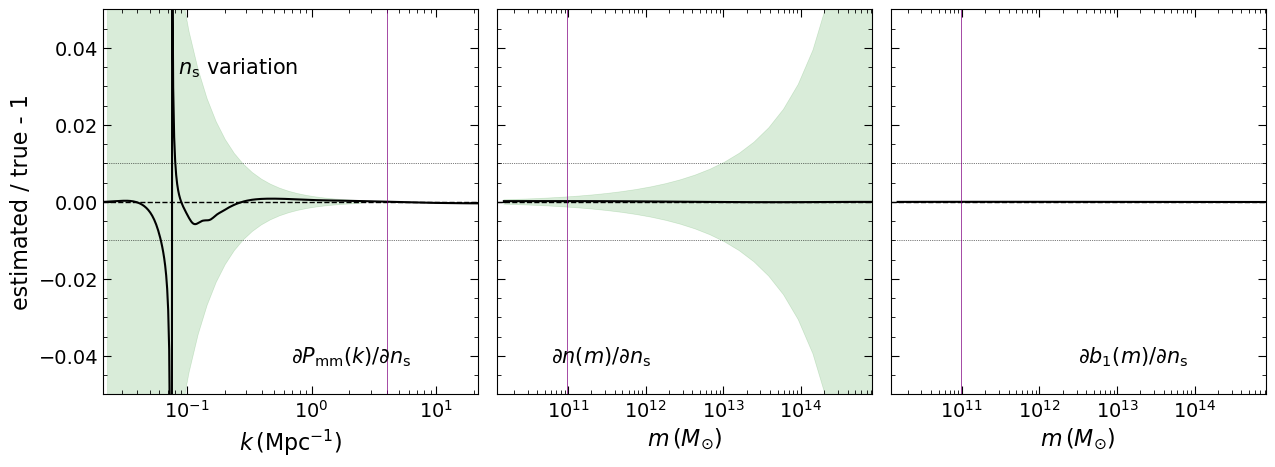

In [21]:
vary_and_plot('ns',0.1*co_fid.ns,co_fid,mvals,var_acc=1e-3*co_fid.ns,sig_thresh=3.0,k_sim=kmid,rePk_sim=rel_err_Pk)

## $A_{\rm s} \pm 10\%$

Varying As...
... transfer functions calculated
type_dict None selected. Using CDM transfer function.
... fiducial statistics calculated
Variations...
... power spectrum
... mass function and bias
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
Estimating derivatives...
... from specified variations
... accurately
... ... transfer functions calculated
... power spectrum
... ... mass function and bias
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
... ... derivatives calculated
0 min 14.34 seconds

Plotting...


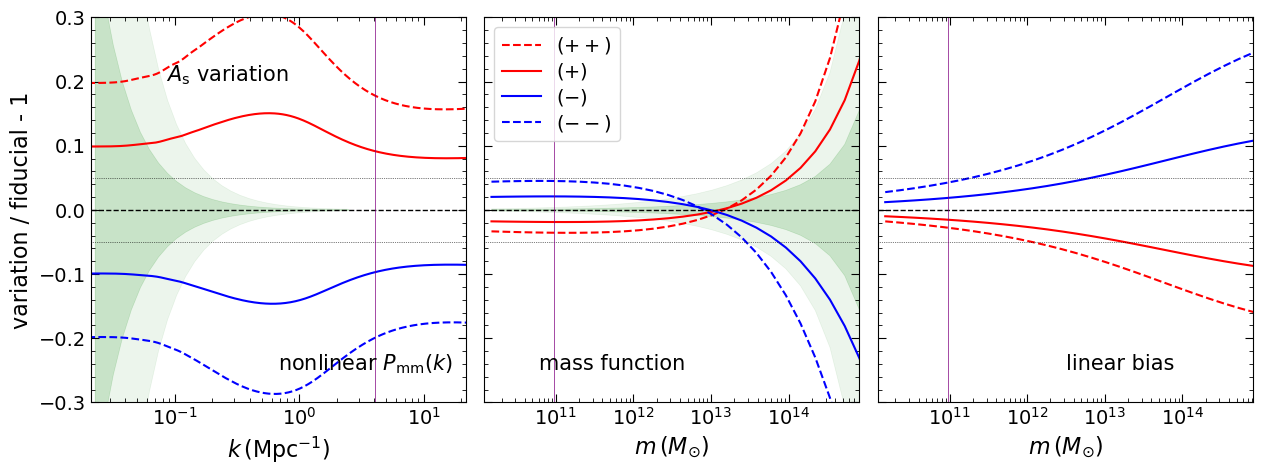

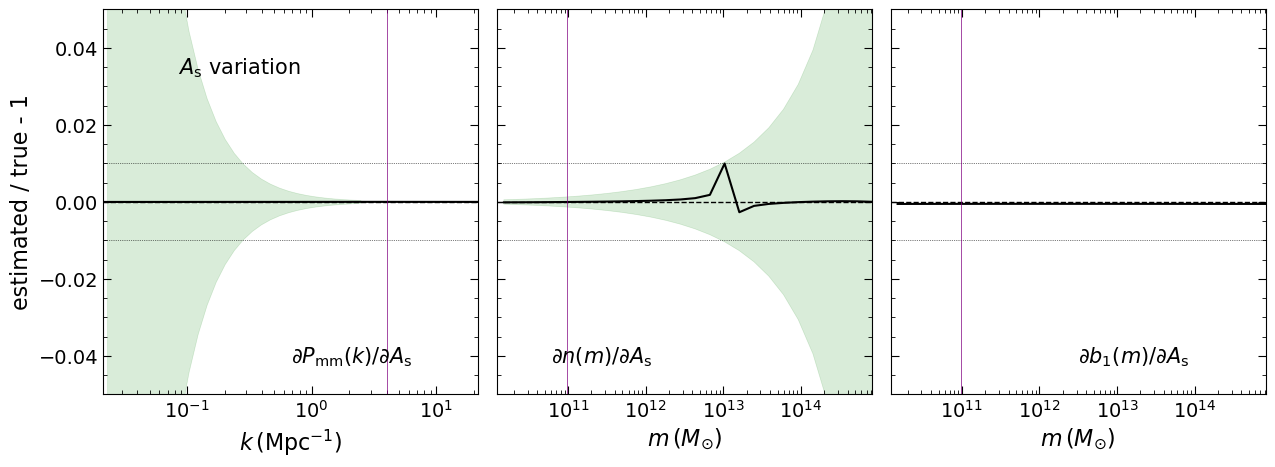

In [20]:
vary_and_plot('As',0.1*co_fid.As,co_fid,mvals,var_acc=1e-3*co_fid.As,sig_thresh=3.0,k_sim=kmid,rePk_sim=rel_err_Pk)

## $h \pm 2\%$

Varying h...
... transfer functions calculated
type_dict None selected. Using CDM transfer function.
... fiducial statistics calculated
Variations...
... power spectrum
... ... interpolating for hubble variation
... mass function and bias
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
... ... rescaling for hubble variation
Estimating derivatives...
... from specified variations
... accurately
... ... transfer functions calculated
... power spectrum
... ... ... interpolating for hubble variation
... ... mass function and bias
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
... ... ... rescaling for hubble variation
... ... derivatives calculated
0 min 15.5

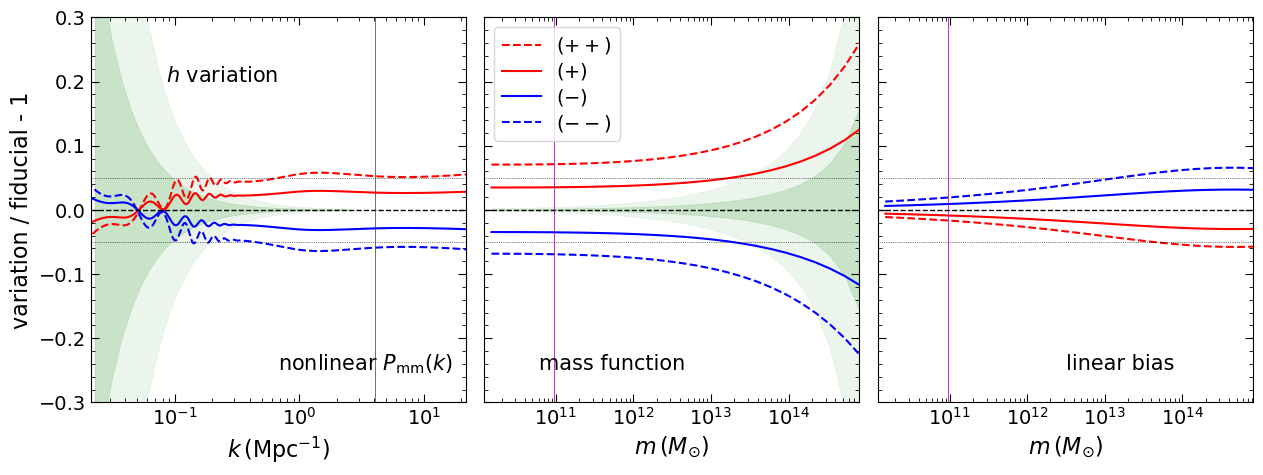

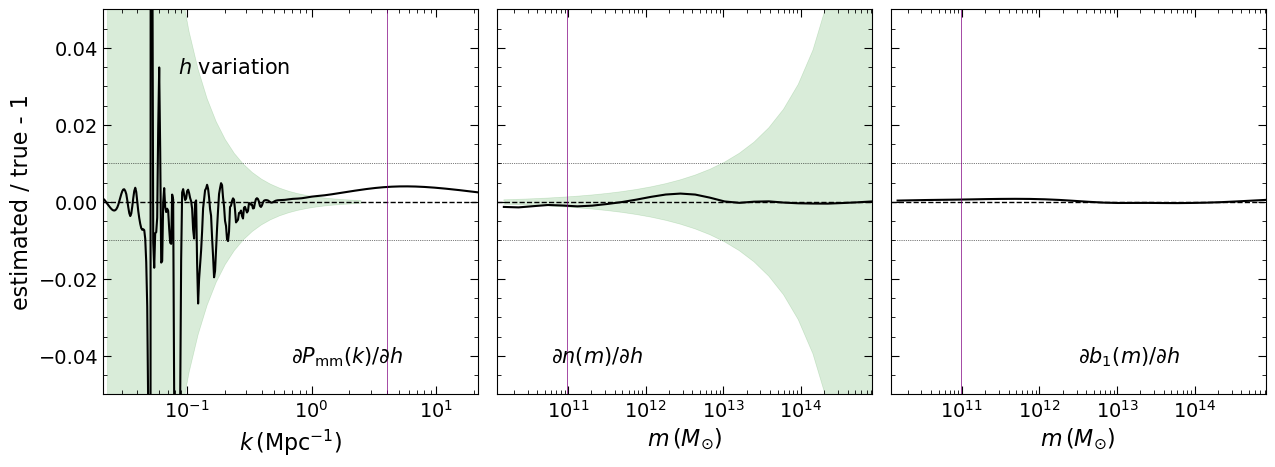

In [15]:
vary_and_plot('h',0.02*co_fid.hubble,co_fid,mvals,var_acc=1e-3*co_fid.hubble,sig_thresh=3.0,k_sim=kmid,rePk_sim=rel_err_Pk)

## $\Omega_{\rm k} \pm 0.02$
High mass effect again challenging, like $\Omega_{\rm b}$. Also not sure if these analytical fits are even correct.

Varying Ok...
... transfer functions calculated
type_dict None selected. Using CDM transfer function.
... fiducial statistics calculated
Variations...
... power spectrum
... mass function and bias
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
Estimating derivatives...
... from specified variations
... accurately
... ... transfer functions calculated
... power spectrum
... ... mass function and bias
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
... ... derivatives calculated
0 min 16.99 seconds

Plotting...


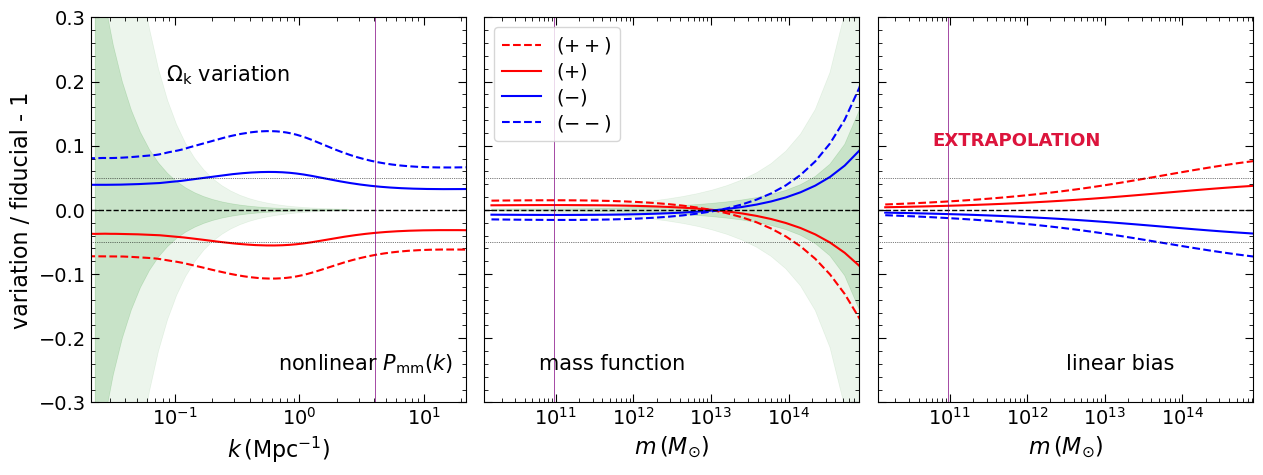

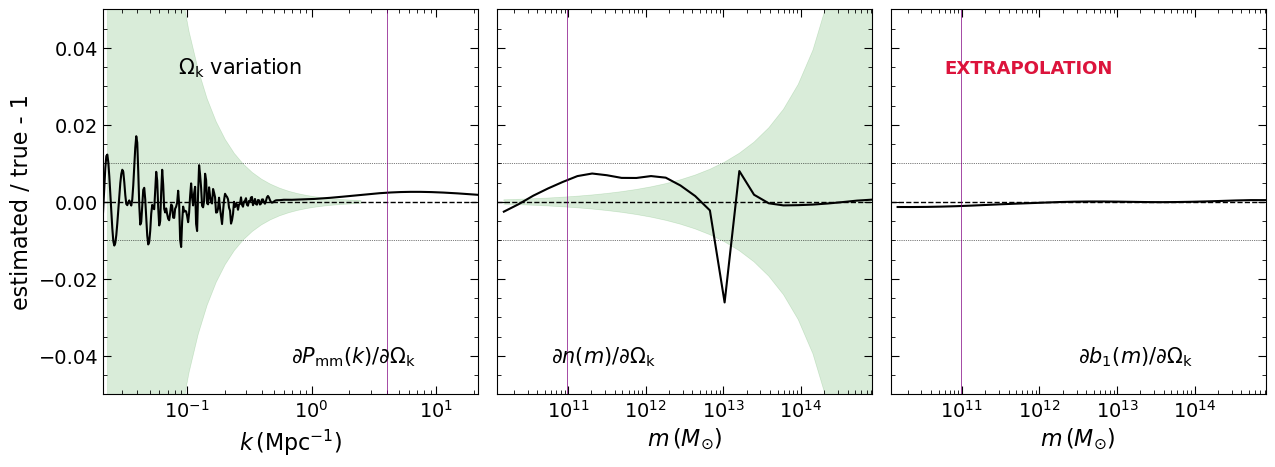

In [12]:
vary_and_plot('Ok',0.02,co_fid,mvals,var_acc=1e-3,sig_thresh=3.0,k_sim=kmid,rePk_sim=rel_err_Pk)

## $w_{0} \pm 10\%$ 
### <span style="color:red"> *not sure about growth factor* </span>

Varying w0...
... transfer functions calculated
type_dict None selected. Using CDM transfer function.
... fiducial statistics calculated
Variations...
... power spectrum
... mass function and bias
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
Estimating derivatives...
... from specified variations
... accurately
... ... transfer functions calculated
... power spectrum
... ... mass function and bias
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
type_dict None selected. Using CDM transfer function.
... ... derivatives calculated
0 min 16.46 seconds

Plotting...


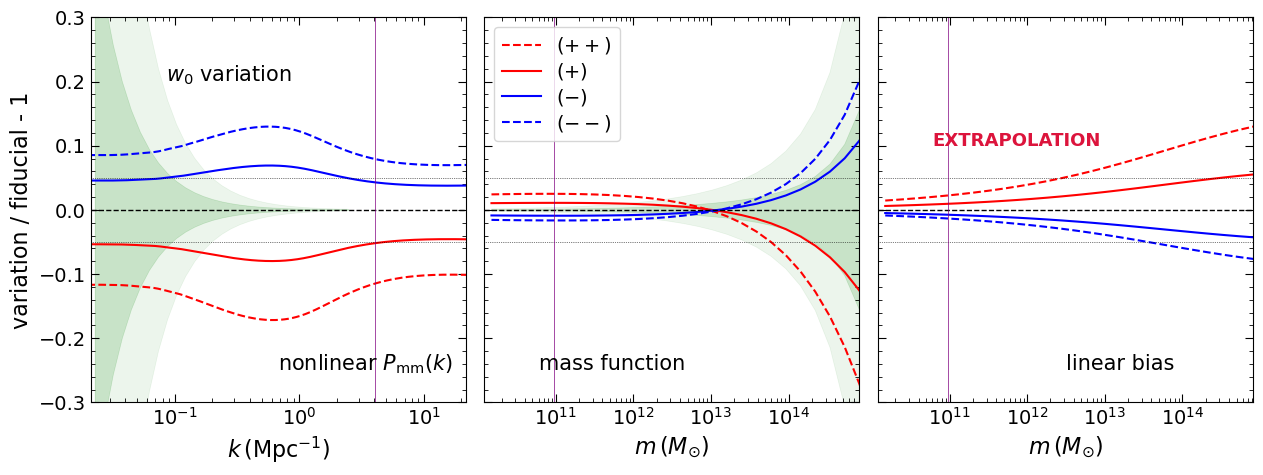

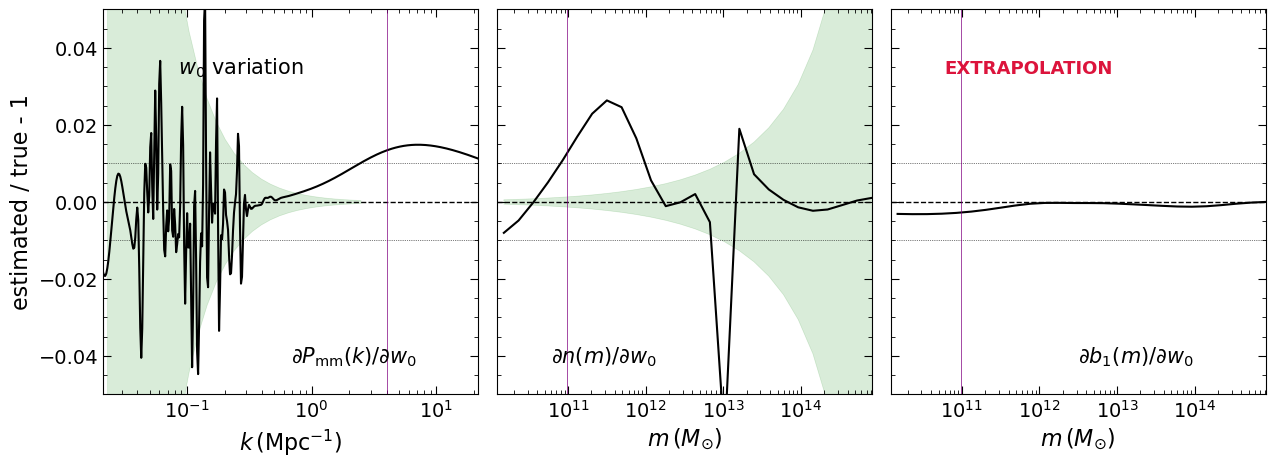

In [13]:
vary_and_plot('w0',0.1*np.fabs(co_fid.wDE0),co_fid,mvals,var_acc=1e-3*np.fabs(co_fid.wDE0),sig_thresh=3.0,
              k_sim=kmid,rePk_sim=rel_err_Pk)